# LightGBM SHAP for predicting use of thrombolysis

This model use 10 features:

* stroke_team_id
* stroke_severity
* prior_disability
* age
* infarction
* onset_to_arrival_time
* precise_onset_known
* onset_during_sleep
* arrival_to_scan_time
* afib_anticoagulant

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shap

from dataclasses import dataclass
from sklearn.ensemble import HistGradientBoostingClassifier

/home/michael/miniconda3/envs/sam10/lib/python3.10/site-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/home/michael/miniconda3/envs/sam10/lib/python3.10/site-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def delta_min

## Set up paths and filenames

In [2]:
@dataclass(frozen=True)
class Paths:
    '''Singleton object for storing paths to data and database.'''

    data_read_path: str = './data/'
    output_folder = './output/'
    model_folder = './models'
    model_text = 'lgbm_decision_'
    notebook: str = '02_'

paths = Paths()

## Load data

In [3]:
# Load data
train = pd.read_csv(paths.data_read_path + 'cohort_10000_train.csv')
train['stroke_team_id'] = train['stroke_team_id'].astype('category')
test = pd.read_csv(paths.data_read_path + 'cohort_10000_test.csv')
test['stroke_team_id'] = test['stroke_team_id'].astype('category')

# Limit by year
low_year = 2016
high_year = 2018
mask = (train['year'] >= low_year) & (train['year'] <= high_year)
train = train[mask]
train.drop('year', inplace=True, axis=1)
mask = (test['year'] >= low_year) & (test['year'] <= high_year)
test = test[mask]
test.drop('year', inplace=True, axis=1)

# Split X and y
X_train = train.drop('thrombolysis', axis=1)
X_test = test.drop('thrombolysis', axis=1)
y_train = train['thrombolysis']
y_test = test['thrombolysis']

# Get features
features = list(X_train)

In [4]:
features

['stroke_team_id',
 'stroke_severity',
 'prior_disability',
 'age',
 'infarction',
 'onset_to_arrival_time',
 'precise_onset_known',
 'onset_during_sleep',
 'arrival_to_scan_time',
 'afib_anticoagulant']

## Fit model

In [5]:
# Define model
model = HistGradientBoostingClassifier(
    random_state=42, categorical_features=[0,2], learning_rate=0.5, early_stopping=False)

# Fit model
model.fit(X_train, y_train)

# Get predictions
predicted = model.predict(X_test)
#predicted_proba = model.predict_proba(X_test)[:,1]

# Show overall accuracy
accuracy = np.mean(predicted == y_test)
print (f'Accuracy: {accuracy:.3f}')

Accuracy: 0.843


## Fit SHAP

In [6]:
explainer = shap.TreeExplainer(model)
shap_values_extended = explainer(X_test)
shap_values = explainer.shap_values(X_test)
shap_values_extended[0]

.values =
array([-1.18425803, -0.54083209, -2.03136038,  0.21603563,  0.85752026,
       -1.00810412, -0.80585727, -2.89254431, -7.05094603,  0.23107435])

.base_values =
array([-4.17091996])

.data =
array([ 20. ,   3. ,   0. ,  72.5,   1. , 186. ,   0. ,   1. , 245. ,
         0. ])

## Show example waterfall plot

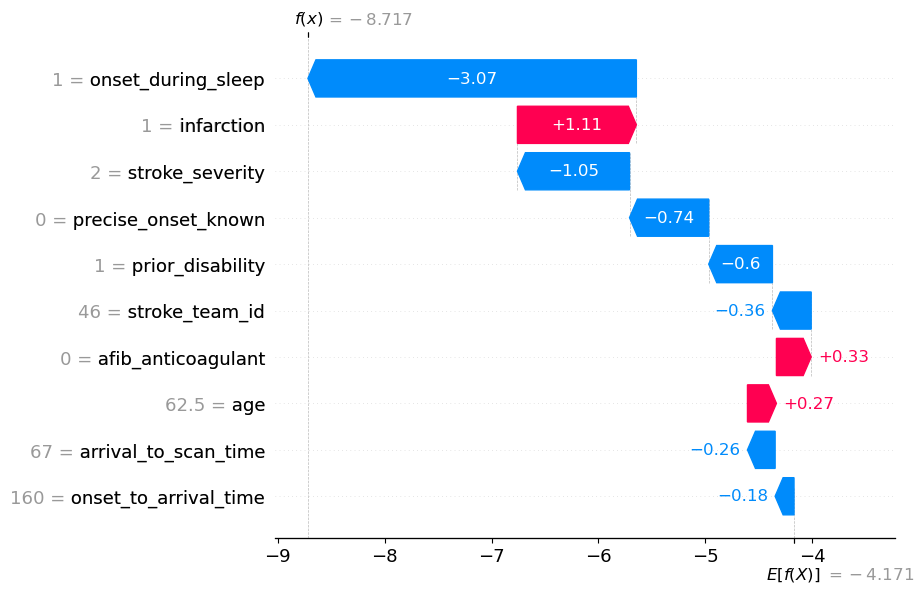

In [7]:
row = 5

shap.waterfall_plot(shap.Explanation(
    values=shap_values_extended[row].values,
    base_values=shap_values_extended[row].base_values[0], 
    data=shap_values_extended[row].data,
    feature_names=X_test.columns.tolist()))

## Beeswarm

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


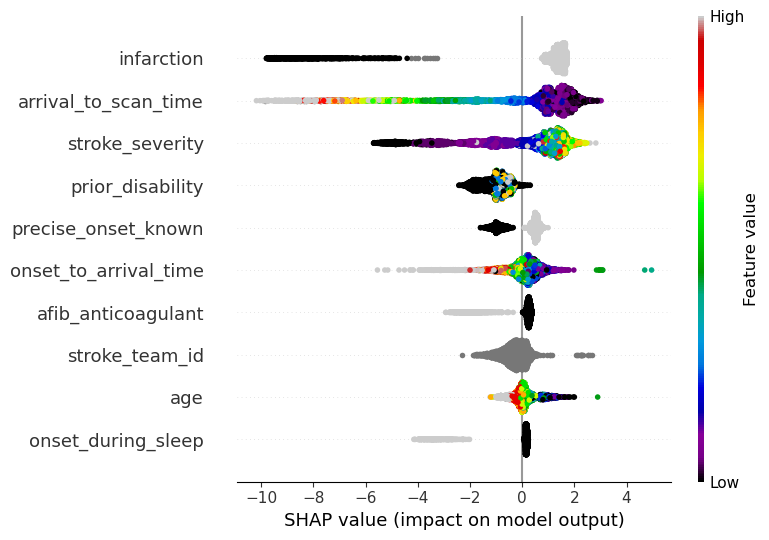

In [8]:
fig = plt.figure(figsize=(6,6))

shap.summary_plot(shap_values=shap_values, 
                  features=X_test,
                  feature_names=features,
                  max_display=10,
                  cmap=plt.get_cmap('nipy_spectral'), show=False)

filename = paths.output_folder + paths.notebook + paths.model_text + 'beeswarm.jpg'
plt.savefig(filename, dpi=300, bbox_inches='tight', pad_inches=0.2)
plt.show()

## Get mean absolute SHAP values

In [9]:
mean_abs_shap = pd.Series(
    np.mean(np.abs(shap_values), axis=0),
    index=features)
mean_abs_shap.sort_values(inplace=True, ascending=False)
mean_abs_shap.round(4)

infarction               2.3323
arrival_to_scan_time     2.0055
stroke_severity          1.5211
prior_disability         1.0471
precise_onset_known      0.6672
onset_to_arrival_time    0.5361
afib_anticoagulant       0.4356
stroke_team_id           0.3973
age                      0.3276
onset_during_sleep       0.3146
dtype: float64

## Get stroke team SHAP

In [10]:
# DataFrame of hopsital SHAP values for all patients
all_team_shap = pd.DataFrame()
all_team_shap['team_id'] = X_test['stroke_team_id']
all_team_shap['SHAP'] = hospital_shap_values = shap_values[:,0]

# Get summary for teams
team_shap = pd.DataFrame()
team_shap['SHAP_mean'] = all_team_shap.groupby('team_id').mean()
team_shap['SHAP_std'] = all_team_shap.groupby('team_id').std()

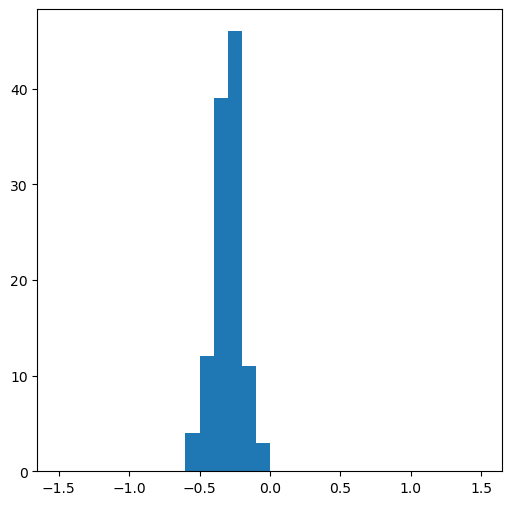

In [11]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot()
ax.hist(team_shap['SHAP_mean'], bins=np.arange(-1.5, 1.51, 0.1))

plt.show()

In [12]:
mean_shap = np.mean(team_shap['SHAP_mean'])
std_shap = np.std(team_shap['SHAP_mean'])
print(f'Mean hospital SHAP: {mean_shap:0.3f}')
print(f'Mean hospital SHAP STDdev: {std_shap:0.3f}')

Mean hospital SHAP: -0.297
Mean hospital SHAP STDdev: 0.097


## Shap Interactions

In [13]:
shap_interactions = explainer.shap_interaction_values(X_test)

In [14]:
hosp_main_effect = shap_interactions[:, 0, 0]

In [15]:
X_test.columns.tolist

<bound method IndexOpsMixin.tolist of Index(['stroke_team_id', 'stroke_severity', 'prior_disability', 'age',
       'infarction', 'onset_to_arrival_time', 'precise_onset_known',
       'onset_during_sleep', 'arrival_to_scan_time', 'afib_anticoagulant'],
      dtype='object')>